# Logistic Regression – Next-Day Direction Classifier

Binary classification: predict whether a stock's **next-day return will be positive (1) or negative/zero (0)**.

**Feature groups:**
- Lagged returns (today, yesterday, 5-day momentum proxy)
- Volatility & momentum (20-day rolling std, price vs MA20)
- Intraday signals (HL range, overnight gap, abnormal volume)
- Macro (VIX, Yield Spread, GMM regime)
- Sentiment (mean score, net ratio, news flag)
- Fundamentals (log market cap, revenue growth, S&P weight)
- Sector encoding

**Time-based split:** train `< 2023-01-01`, test `≥ 2023-01-01`

> Sparse columns (VIX, Yield Spread, sentiment) are imputed with their median / 0 rather than dropped so the full row set is preserved.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Load Data

In [2]:
df = pd.read_csv('../data/merged_dataset.csv', parse_dates=['date'])
print(f'Shape: {df.shape}')
print(f'Date range: {df["date"].min().date()} – {df["date"].max().date()}')
print(f'Tickers: {df["ticker"].nunique():,}')
df.head(3)

Shape: (1264542, 43)
Date range: 2016-02-10 – 2026-02-09
Tickers: 503


,date,ticker,adj_close,close,high,low,open,volume,daily_return,log_return,...,Yield_Spread,Regime_GMM,Regime_label,news_count,sentiment_mean,sentiment_sum,positive_count,negative_count,neutral_count,sentiment_ratio
0,2016-02-10,A,33.100433,35.849998,36.730000,35.529999,35.630001,3170000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-11,A,32.620323,35.330002,35.610001,34.939999,35.119999,3224000.0,-0.014505,-0.014611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-12,A,33.442055,36.220001,36.230000,35.520000,35.840000,3923600.0,0.025191,0.024879,...,0.027053,0.0,Stressful,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Feature Engineering

In [3]:
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ── Target: next-day direction ────────────────────────────────────────────────
df['next_return'] = df.groupby('ticker')['daily_return'].shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

# ── Lagged returns ────────────────────────────────────────────────────────────
df['lag_return_1'] = df['daily_return']                                  # today
df['lag_return_2'] = df.groupby('ticker')['daily_return'].shift(1)       # yesterday
df['lag_return_5'] = df.groupby('ticker')['daily_return'].shift(4)       # 5-day proxy

# ── Price vs 20-day MA ────────────────────────────────────────────────────────
df['price_to_ma20'] = (
    df['close'] / df['rolling_mean_20'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan) - 1

# ── Intraday range ────────────────────────────────────────────────────────────
df['hl_range'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan)

# ── Overnight gap ─────────────────────────────────────────────────────────────
df['prev_close'] = df.groupby('ticker')['close'].shift(1)
df['oc_gap'] = (
    (df['open'] - df['prev_close']) / df['prev_close'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan)

# ── Abnormal volume ───────────────────────────────────────────────────────────
df['vol_20ma'] = df.groupby('ticker')['volume'].transform(
    lambda x: x.rolling(20, min_periods=1).mean()
)
df['vol_norm'] = (df['volume'] / df['vol_20ma'].replace(0, np.nan)).clip(0, 10)

# ── News flag ─────────────────────────────────────────────────────────────────
df['has_news'] = (df['news_count'].fillna(0) > 0).astype(float)

# ── Log market cap ────────────────────────────────────────────────────────────
df['log_marketcap'] = np.log1p(df['Marketcap'].fillna(0))

# ── Impute sparse macro & sentiment columns ───────────────────────────────────
df['VIX']             = df['VIX'].fillna(df['VIX'].median())
df['Yield_Spread']    = df['Yield_Spread'].fillna(df['Yield_Spread'].median())
df['Regime_GMM']      = df['Regime_GMM'].fillna(df['Regime_GMM'].median())
df['sentiment_mean']  = df['sentiment_mean'].fillna(0)
df['sentiment_ratio'] = df['sentiment_ratio'].fillna(0)
df['Revenuegrowth']   = df['Revenuegrowth'].fillna(0)
df['Weight']          = df['Weight'].fillna(0)

# ── Sector encoding ───────────────────────────────────────────────────────────
df['Sector_encoded'] = df['Sector'].astype('category').cat.codes

print(f'Shape after feature engineering: {df.shape}')

Shape after feature engineering: (1264542, 57)


## 3. Feature Selection & Class Balance

In [ ]:
FEATURE_COLS = [
    'lag_return_1',    # today's return
    'lag_return_2',    # yesterday's return
    'lag_return_5',    # 5-day momentum proxy
    'rolling_std_20',  # 20-day price volatility
    'price_to_ma20',   # price relative to 20-day MA
    'hl_range',        # intraday high-low range
    'oc_gap',          # overnight gap
    'vol_norm',        # abnormal volume (clipped)
    'VIX',             # market fear index
    'Yield_Spread',    # yield curve macro signal
    'Regime_GMM',      # market regime (0/1/2)
    'sentiment_mean',  # news sentiment score (0 if no news)
    'sentiment_ratio', # net sentiment ratio
    'has_news',        # binary news coverage flag
    'log_marketcap',   # log market capitalisation
    'Revenuegrowth',   # fundamental growth
    'Weight',          # S&P 500 index weight
    'Sector_encoded',  # sector as integer
]

model_df = df[FEATURE_COLS + ['target', 'date']].dropna()
print(f'Rows after dropna: {len(model_df):,}')

# pos_rate = model_df['target'].mean()
# print(f'Class balance — Up: {pos_rate:.2%}  Down: {1-pos_rate:.2%}')
# print(f'Naive baseline (always predict Up): {pos_rate:.4f} accuracy')

Rows after dropna: 1,219,484
Class balance — Up: 52.46%  Down: 47.54%
Naive baseline (always predict Up): 0.5246 accuracy


## 4. Time-Based Train / Test Split

In [5]:
SPLIT_DATE = '2023-01-01'

train = model_df[model_df['date'] <  SPLIT_DATE]
test  = model_df[model_df['date'] >= SPLIT_DATE]

X_train, y_train = train[FEATURE_COLS].values, train['target'].values
X_test,  y_test  = test[FEATURE_COLS].values,  test['target'].values

print(f'Train: {len(train):,} rows  ({train["date"].min().date()} – {train["date"].max().date()})')
print(f'Test:  {len(test):,}  rows  ({test["date"].min().date()} – {test["date"].max().date()})')

Train: 830,418 rows  (2016-03-09 – 2022-12-30)
Test:  389,066  rows  (2023-01-03 – 2026-02-09)


## 5. Scale Features & Train Model

In [6]:
baseline = max(0.5003, 0.5223, 0.4961, 0.4881)

In [8]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# saga solver handles large datasets efficiently; C=0.1 adds L2 regularisation
# model = LogisticRegression(
#     solver='saga', penalty='l2', C=0.1,
#     max_iter=500, random_state=42, n_jobs=-1,
# )

model = LogisticRegressionCV(Cs=100, n_jobs=-1)
model.fit(X_train_s, y_train)
print('Training complete.')

Training complete.


Best C : 0.001630, Best accuracy : 0.5267
Majority-class baseline : 0.5223


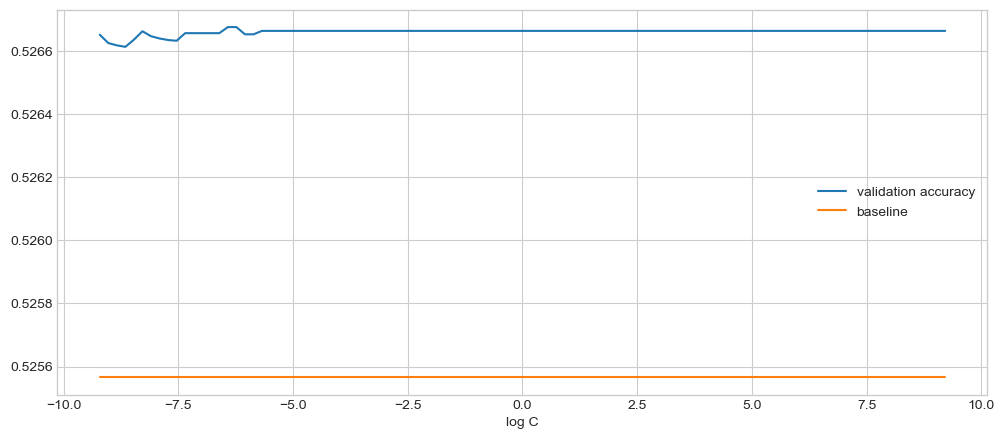

In [12]:
results = pd.DataFrame()
results['log C'] = np.log(model.Cs_)
results['validation accuracy'] = model.scores_[1].mean(axis=0)
results['baseline'] = pd.Series(y_train).value_counts(normalize=True).max()

results.plot.line(x='log C', y=['validation accuracy', 'baseline'])

print(f'Best C : {model.C_[0]:.6f}, Best accuracy : {results["validation accuracy"].max():.4f}')
print(f'Majority-class baseline : {baseline:.4f}')

In [13]:
y_pred = model.predict(X_test_s)                                                                                                        
                                                                                                                                          
print(f'Accuracy : {accuracy_score(y_test, y_pred):.4f}  (baseline: {baseline:.4f})')                                                
print()
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

Accuracy : 0.5182  (baseline: 0.5223)

              precision    recall  f1-score   support

        Down       0.48      0.10      0.16    185824
          Up       0.52      0.90      0.66    203242

    accuracy                           0.52    389066
   macro avg       0.50      0.50      0.41    389066
weighted avg       0.50      0.52      0.42    389066



# =======
# Everything below this is under development and may be incomplete or inaccurate.
# =======

## 6. Evaluation

In [ ]:
y_pred = model.predict(X_test_s)
naive  = max(y_test.mean(), 1 - y_test.mean())

print(f'Accuracy : {accuracy_score(y_test, y_pred):.4f}  (naive baseline: {naive:.4f})')
print()
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

## 7. Coefficient Analysis

Because features are standardised, coefficients are comparable in magnitude.
Positive → feature pushes toward predicting **Up**; negative → toward **Down**.

In [ ]:
coef_df = pd.DataFrame({
    'feature':     FEATURE_COLS,
    'coefficient': model.coef_[0],
}).sort_values('coefficient')

colors = ['salmon' if c < 0 else 'steelblue' for c in coef_df['coefficient']]

plt.figure(figsize=(10, 7))
plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
plt.axvline(0, color='black', lw=0.8)
plt.title('Logistic Regression Coefficients (Standardised Features)')
plt.xlabel('Coefficient  →  positive pushes toward "Up" prediction')
plt.tight_layout()
plt.show()

## 8. Regularisation Strength Sweep (C parameter)

Sweep `C` to understand the accuracy trade-off from heavy to light regularisation.

In [ ]:
C_values = [0.001, 0.01, 0.1, 1.0, 10.0]
accs = []

for C in C_values:
    m = LogisticRegression(
        solver='saga', penalty='l2', C=C,
        max_iter=300, random_state=42, n_jobs=-1,
    )
    m.fit(X_train_s, y_train)
    accs.append(accuracy_score(y_test, m.predict(X_test_s)))

plt.figure(figsize=(7, 4))
plt.plot(C_values, accs, marker='o')
plt.xscale('log')
plt.title('Accuracy vs C')
plt.xlabel('C (inverse regularisation strength)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

print('C         Accuracy')
for C, a in zip(C_values, accs):
    print(f'  {C:<8}  {a:.4f}')